In [7]:
import pandas as pd
import os
import kagglehub
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import ast
import torch
from torch.utils.data import Dataset
from PIL import Image, ImageDraw
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

In [8]:
import utility_rayon_x_df as rayon

# Importation des données

On gare seulement les colonnes des maladies (normalisées) et le chemin de l'image

In [10]:
df = pd.read_csv("/kaggle/input/rayon-x-label/DB_patients_norm_bbox.csv")
df_pytorch = df.drop(df.columns[0:12], axis=1).copy()
df.head(2)


,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],...,Emphysema,Fibrosis,Pleural_Thickening,Hernia,No Finding,Image Path,x,y,w,h
0,0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,...,0,0,0,0,0,/kaggle/input/data/images_001/images/00000001_...,False,False,False,False
1,1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,...,1,0,0,0,0,/kaggle/input/data/images_001/images/00000001_...,False,False,False,False


# Création de la classe RayonX

Dataset personnalisé pour PyTorch

Permet d'initialiser une instance (le dataset) et interagir avec son contenu (afficher image avec ses labels...)

In [11]:
class RayonX(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Dataset personnalisé pour des images de rayons X multiclasse/multi-label.

        Args:
            dataframe (pd.DataFrame): Contient les chemins d'accès relatifs et les labels.
            root_dir (str or Path): Dossier racine contenant les images.
            transform (callable, optional): Transformations à appliquer aux images.
        """
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform

        # Colonnes des labels (toutes sauf 'Image Path')
        self.label_cols = [col for col in self.df.columns if col != 'Image Path']
        
        # Chemins relatifs des images
        self.image_paths = self.df['Image Path'].values

        # Matrice de labels binaires (multi-label)
        self.labels = self.df[self.label_cols].values.astype(float)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx): 
        # Chemin absolu de l'image
        relative_path = self.image_paths[idx]
        image_path = os.path.join(self.root_dir, relative_path)

        # Chargement de l'image en RGB
        image = Image.open(image_path).convert("RGB")
        print(image_path)  # Debug (à retirer ou logger proprement en prod)

        # Application des transformations si présentes
        if self.transform:
            image = self.transform(image)

        # Extraction du label
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label   

    def __afficher_image__(self, idx):
        """
        Affiche l'image (dénormalisée) et ses labels associés.
        """
        image, label = self[idx]

        # Dénormalisation
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = image * std + mean  # Inverser la normalisation

        # Passage à la forme (H, W, C) pour matplotlib
        image = image.permute(1, 2, 0).clamp(0, 1)

        # Affichage
        import matplotlib.pyplot as plt
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

        # Affichage des maladies détectées
        print("Maladies présentes :")
        for i in range(len(label)):
            if label[i] == 1:
                print(f" - {self.label_cols[i]}")

# Création de la class Bbox

In [12]:
class BBoxDataset(Dataset):
    def __init__(self, dataframe, image_root, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_root = image_root  # Dossier Kaggle contenant les images
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        print(row.iloc[-1])
        image_path = row.iloc[-1]
        image = Image.open(image_path).convert("RGB")

        bbox = (
            float(row['Bbox [x']),
            float(row['y']),
            float(row['w']),
            float(row['h]'])
        )

        # Appliquer transformation (optionnel)
        if self.transform:
            image = self.transform(image)

        return image,bbox
    
    def show_image_with_bbox(self, idx):
        row = self.df.iloc[idx]
        image, _ = self.__getitem__(idx)
        x, y, w, h = (
            float(row['Bbox [x']),
            float(row['y']),
            float(row['w']),
            float(row['h]'])
        )
    
        # Dessiner la bbox
        image_copy = image.copy() if isinstance(image, Image.Image) else transforms.ToPILImage()(image)
        draw = ImageDraw.Draw(image_copy)
        draw.rectangle([x, y, x + w, y + h], outline="red", width=2)
    
        # Afficher
        plt.imshow(image_copy)
        plt.title(f"Image: {row['Image Index']} - {row['Finding Label']}")
        plt.axis("off")
        plt.show()

# Transformation / Data augmentation

In [13]:
data_augmentation = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [14]:
transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Création du dataset

## Séparation PA et AP

In [15]:
df_ap = df[df["View Position"] == "AP"]
df_pa = df[df["View Position"] == "PA"]

print(df_ap.shape, df_pa.shape)

(44810, 32) (67310, 32)


## Suppression des images en doubles

In [16]:
def recup_une_maladie(df, maladie):
    # Suppression des colonnes d'information non liées aux labels
    df_maladies = df.drop(df.columns[0:12], axis=1).copy()

    # Vérification que la maladie est bien dans les colonnes
    if maladie not in df_maladies.columns:
        raise ValueError(f"La colonne '{maladie}' n'existe pas dans les labels du DataFrame.")
    
    # Liste des colonnes sauf 'Image Path'
    label_cols = [col for col in df_maladies.columns if col != 'Image Path']
    
    # Sélection des lignes avec un seul '1' dans toutes les colonnes maladies
    single_label_rows = df_maladies[label_cols].sum(axis=1) == 1
    
    # Ensuite on garde uniquement celles où le '1' est dans la colonne correspondant à la maladie voulue
    filtre_maladie = df_maladies[maladie] == 1

    # On applique les deux filtres
    df_filtré = df_maladies[single_label_rows & filtre_maladie]
    
    return df_filtré


def compter_occurrences_maladies(df, colonnes_maladies):
    """
    Crée un DataFrame contenant :
    - le nom de la maladie,
    - le nombre d'occurrences où la maladie est seule (unique),
    - le nombre total d'occurrences de la maladie (multi inclus),
    trié par ordre décroissant des occurrences totales.
    
    Args:
        df (pd.DataFrame): le DataFrame contenant les colonnes des maladies (valeurs 0 ou 1).
        colonnes_maladies (list): liste des colonnes correspondant aux maladies.
    
    Returns:
        pd.DataFrame: un DataFrame trié avec 3 colonnes : "maladie", "occ maladie unique", "occ multi maladie".
    """
    df_maladies = df[colonnes_maladies].copy()
    df_unique = df_maladies[df_maladies.sum(axis=1) == 1]

    resultats = []

    for maladie in colonnes_maladies:
        occ_unique = df_unique[maladie].sum()
        occ_total = df_maladies[maladie].sum()
        occ_multi = occ_total - occ_unique
        resultats.append({
            "maladie": maladie,
            "occ maladie unique": int(occ_unique),
            "occ multi maladie": int(occ_total)
        })

    df_resultats = pd.DataFrame(resultats)
    df_resultats = df_resultats.sort_values(by="occ multi maladie", ascending=False).reset_index(drop=True)
    return df_resultats
    
def lignes_doublons_no_finding(df):
    cols_sans_b = [col for col in df_ap.columns if col not in ["Image Index", "Finding Labels", "Patient Age", "Follow-up #","OriginalImage[Width", "Height]",
                                                        "OriginalImagePixelSpacing[x","y]","Unnamed: 11", "Image Path"]]

    doublons = df_ap[(df_ap.duplicated(subset=cols_sans_b, keep=False)) & (df["No Finding"] == 1)]
    cols_sans_b.append("Image Index")
    print("Lignes en double (no finding): ", doublons.shape[0])
    print("Taille du dataset sans ces doublons: ", df.shape[0] - doublons.shape[0])

    
    return doublons[cols_sans_b]

def supprimer_doublons_garder_premier(df):
    cols_sans_b = [col for col in df.columns if col not in [
        "Image Index", "Finding Labels", "Patient Age", "Follow-up #", "OriginalImage[Width", "Height]",
        "OriginalImagePixelSpacing[x", "y]", "Unnamed: 11", "Image Path"
    ]]

    df_no_finding = df[df["No Finding"] == 1]
    df_no_finding_sans_doublons = df_no_finding.drop_duplicates(subset=cols_sans_b, keep="first")
    df_avec_maladie = df[df["No Finding"] != 1]
    
    df_final = pd.concat([df_no_finding_sans_doublons, df_avec_maladie], ignore_index=True)
    
    print("\nNombre de lignes gardées (maladies + un no finding max par patient):", df_final.shape[0])
    return df_final

def afficher_toutes_les_image_patient(id_patient, df, root_dir="."):
    patient_rows = df[df["Patient ID"] == id_patient]

    if patient_rows.empty:
        print(f"Aucune image trouvée pour le patient {id_patient}")
        return

    for _, row in patient_rows.iterrows():
        image_path = os.path.join(root_dir, row["Image Path"])
        try:
            image = Image.open(image_path).convert("RGB")
            plt.imshow(image)
            plt.title(f"{row['Image Index']}, {row['Finding Labels']}")
            plt.axis('off')
            plt.show()
            
        except Exception as e:
            print(f"Erreur lors de l'ouverture de {image_path}: {e}")

In [17]:
maladies = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding'
]

compter_occurrences_maladies(df, maladies)

,maladie,occ maladie unique,occ multi maladie
0,No Finding,60361,60361
1,Infiltration,9547,19894
2,Effusion,3955,13317
3,Atelectasis,4215,11559
4,Nodule,2705,6331
5,Mass,2139,5782
6,Pneumothorax,2194,5302
7,Consolidation,1310,4667
8,Pleural_Thickening,1126,3385
9,Cardiomegaly,1093,2776


### AP

* Visualisation de la répartition des maladies

In [21]:
doublons = lignes_doublons_no_finding(df_ap)

df_ap_nettoye = supprimer_doublons_garder_premier(df_ap)

Lignes en double (no finding):  0
Taille du dataset sans ces doublons:  44810

Nombre de lignes gardées (maladies + un no finding max par patient): 44810


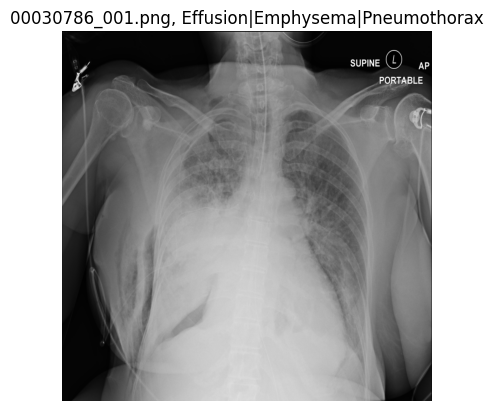

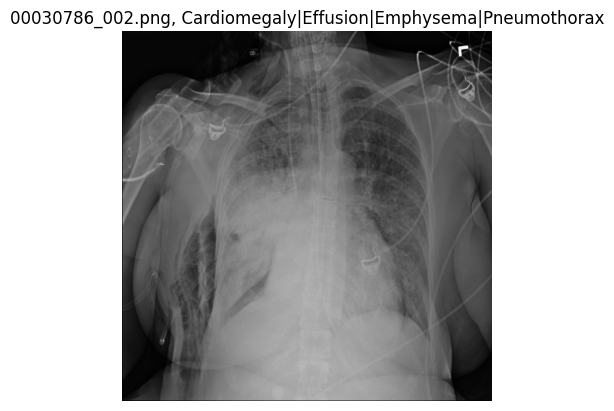

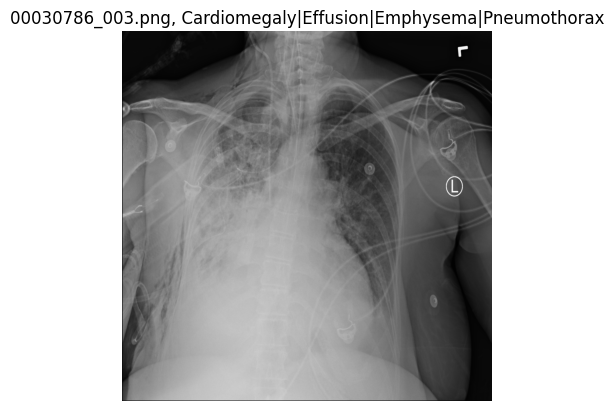

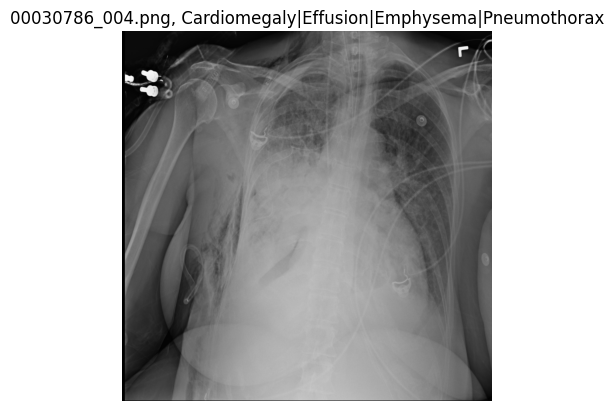

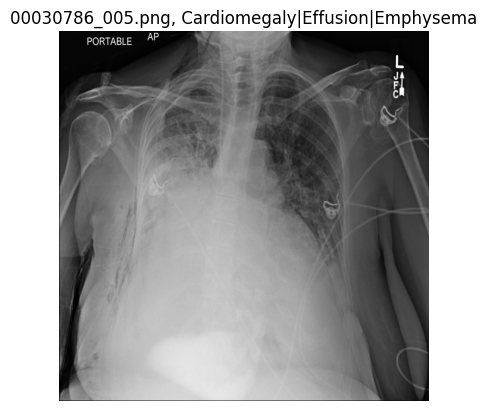

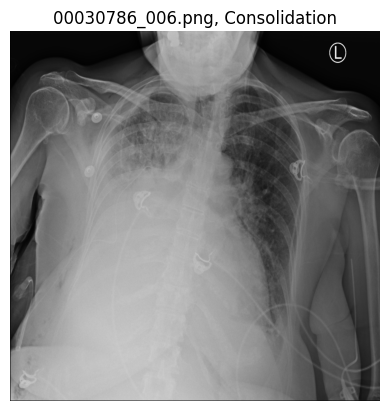

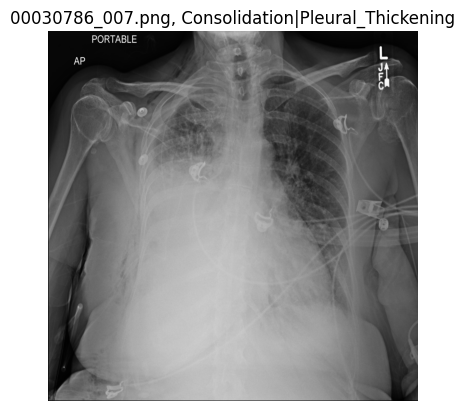

In [23]:
afficher_toutes_les_image_patient(30786, df_ap_nettoye)

### Total

In [27]:
def lignes_doublons(df):
    cols_sans_b = [col for col in df_ap.columns if col not in ["Image Index", "Finding Labels", "Follow-up #","OriginalImage[Width", "Height]",
                                                        "OriginalImagePixelSpacing[x","y]","Unnamed: 11", "Image Path"]]

    doublons = df_ap[(df_ap.duplicated(subset=cols_sans_b, keep=False)) & (df["No Finding"] == 1)]
    cols_sans_b.append("Image Index")
    return doublons[cols_sans_b]

In [28]:
cols_sans_b = [col for col in df.columns if col not in ["Image Index", "Finding Labels", "Follow-up #","OriginalImage[Width", "Height]",
                                                        "OriginalImagePixelSpacing[x","y]","Unnamed: 11", "Image Path"]]
# df[df[""]]
doublons = df[df.duplicated(subset=cols_sans_b, keep=False)]
cols_sans_b.append("Image Path")
doublons[cols_sans_b]

,Unnamed: 0,Patient ID,Patient Age,Patient Gender,View Position,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,...,Emphysema,Fibrosis,Pleural_Thickening,Hernia,No Finding,x,y,w,h,Image Path


# ROI

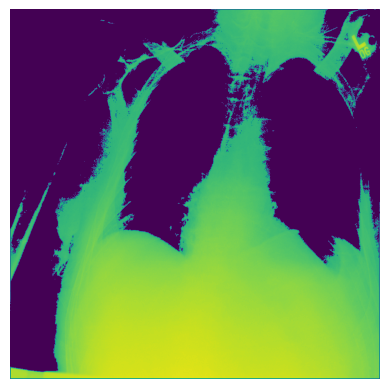

In [34]:
from skimage import io, morphology

def remove_background(image, mask):
    return image * mask

# 🔁 Charger l'image
image = io.imread('/kaggle/input/data/images_001/images/00000015_000.png', as_gray=True)

# ✅ Créer un masque binaire de même forme que l’image
mask = image > image.mean()

# 🎯 Appliquer le masque pour retirer l’arrière-plan
processed_image = remove_background(image, mask)

plt.imshow(processed_image)

# Masquer les axes
plt.axis('off')

# Afficher la figure
plt.show()

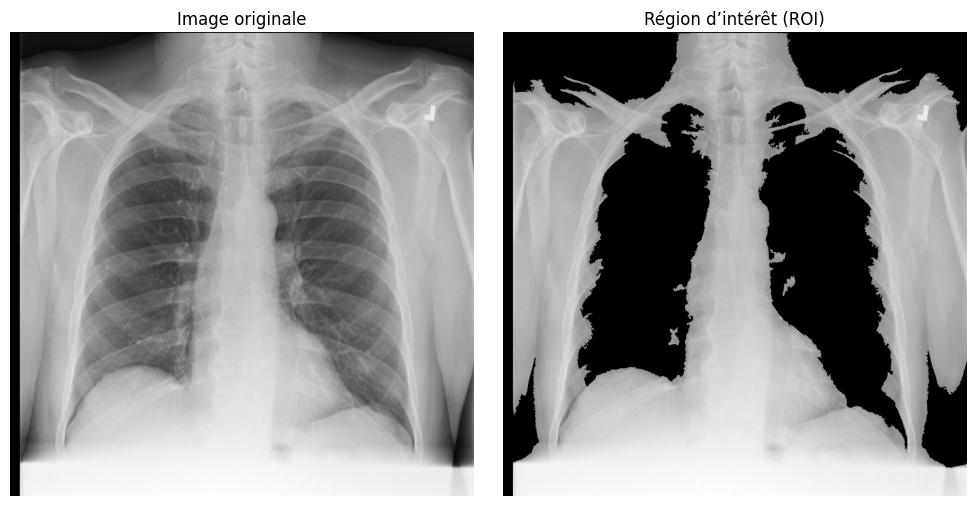

In [35]:
import numpy as np
from skimage import io, filters, morphology
import matplotlib.pyplot as plt

# Charger l'image en niveaux de gris
image = io.imread('/kaggle/input/data/images_001/images/00000152_000.png', as_gray=True)

# Appliquer un seuillage pour créer un masque binaire
threshold = filters.threshold_otsu(image)
mask = image > threshold

# Nettoyer le masque en supprimant les petits objets et en comblant les trous
mask = morphology.remove_small_objects(mask, min_size=500)
mask = morphology.remove_small_holes(mask, area_threshold=500)

# Appliquer le masque à l'image
roi = image * mask

# Afficher l'image originale et la ROI
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Image originale')
axes[0].axis('off')

axes[1].imshow(roi, cmap='gray')
axes[1].set_title('Région d’intérêt (ROI)')
axes[1].axis('off')

plt.tight_layout()
plt.show()


# Débruiter

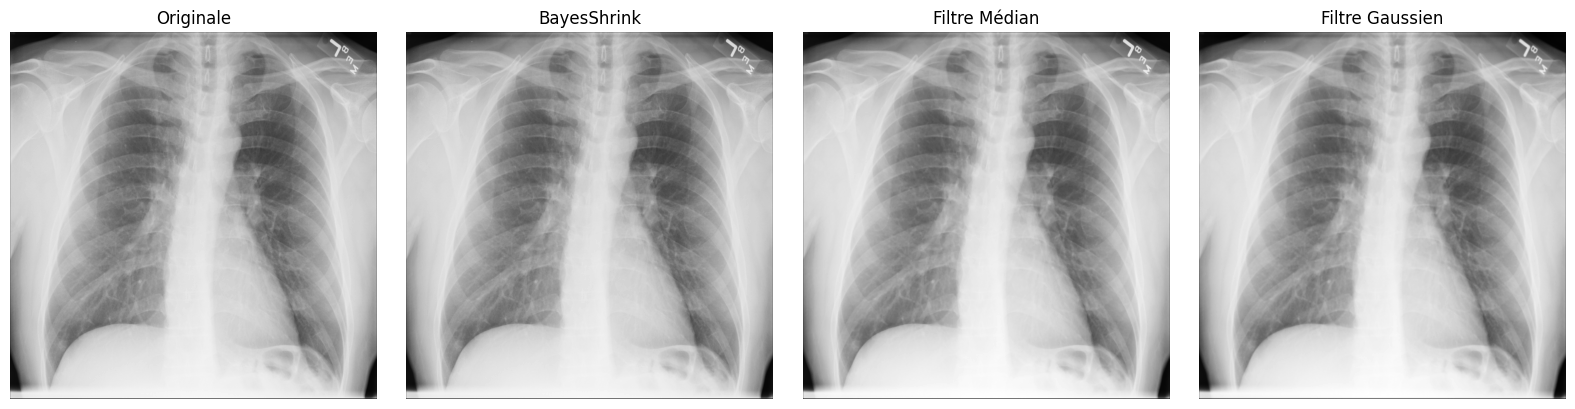

In [28]:
import matplotlib.pyplot as plt
from skimage import io, filters, restoration
from skimage.restoration import denoise_wavelet
from skimage.morphology import disk
from skimage.filters import median, gaussian

# 📥 Charger l'image en niveaux de gris
image = io.imread('/kaggle/input/data/images_001/images/00000572_000.png', as_gray=True)

# 1️⃣ Débruitage avec ondelettes (BayesShrink)
denoised_wavelet = denoise_wavelet(image, method='BayesShrink', mode='soft', rescale_sigma=True)

# 2️⃣ Filtre médian
denoised_median = median(image, disk(2))

# 3️⃣ Filtre gaussien
denoised_gaussian = gaussian(image, sigma=1)

# 📊 Affichage comparatif
titles = ['Originale', 'BayesShrink', 'Filtre Médian', 'Filtre Gaussien']
images = [image, denoised_wavelet, denoised_median, denoised_gaussian]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()
